# Model Development - Aprix Lead Scoring System

This notebook contains the machine learning model development and evaluation.

In [1]:
# Import all required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Sklearn imports
from sklearn.model_selection import train_test_split, cross_val_score, validation_curve, learning_curve, StratifiedKFold, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.base import BaseEstimator, TransformerMixin

from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression

import warnings
warnings.filterwarnings('ignore')

plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = [10, 6]


## Outlier Treatment Class

Custom transformer for handling outliers using the IQR method with 1.5*IQR rule for capping extreme values.


In [2]:
class SimpleOutlierCapper(BaseEstimator, TransformerMixin):
    def __init__(self, multiplier=1.5):
        self.multiplier = multiplier
        self.bounds_ = {}
        
    def fit(self, X, y=None):
        for col in X.columns:
            Q1 = X[col].quantile(0.25)
            Q3 = X[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - self.multiplier * IQR
            upper_bound = Q3 + self.multiplier * IQR
            self.bounds_[col] = {'lower': lower_bound, 'upper': upper_bound}
        return self
    
    def transform(self, X):
        X_transformed = X.copy()
        for col in X.columns:
            if col in self.bounds_:
                lower = self.bounds_[col]['lower']
                upper = self.bounds_[col]['upper']
                X_transformed[col] = X_transformed[col].clip(lower=lower, upper=upper)
        return X_transformed


## Data Loading and Preprocessing

In [3]:
df = pd.read_excel('../data/raw/data.xlsx', sheet_name=1)
df['faturamento_anual_milhoes'] = df['faturamento_anual_milhoes'].apply(
    lambda x: float(x.day + x.month/10) if isinstance(x, datetime) else float(x)
)
X_initial = df.drop('converted', axis=1)
y = df['converted']

X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X_initial, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Initial split - Training set: {X_train_raw.shape[0]} samples")
print(f"Initial split - Test set: {X_test_raw.shape[0]} samples")
print(f"Training conversion rate: {y_train.mean():.1%}")
print(f"Test conversion rate: {y_test.mean():.1%}")


Initial split - Training set: 240 samples
Initial split - Test set: 60 samples
Training conversion rate: 47.9%
Test conversion rate: 48.3%


In [4]:
def create_enhanced_features(df, reference_stats=None):
    """Enhanced feature engineering with interaction terms and advanced ratios"""
    df_enhanced = df.copy()
    
    # Calculate reference stats if not provided (for training set)
    if reference_stats is None:
        reference_stats = {
            'max_revenue': df_enhanced['faturamento_anual_milhoes'].max(),
            'max_skus': df_enhanced['numero_SKUs'].max(),
            'max_margin': df_enhanced['margem_media_setor'].max(),
            'max_meetings': df_enhanced['reunioes_realizadas'].max(),
            'max_emails_sent': df_enhanced['emails_enviados'].max(),
            'max_days': df_enhanced['days_since_first_touch'].max()
        }
    
    # Basic engagement ratios
    df_enhanced['email_open_rate'] = np.where(df_enhanced['emails_enviados'] > 0, 
                                            df_enhanced['emails_abertos'] / df_enhanced['emails_enviados'], 0)
    df_enhanced['email_response_rate'] = np.where(df_enhanced['emails_abertos'] > 0, 
                                                df_enhanced['emails_respondidos'] / df_enhanced['emails_abertos'], 0)
    df_enhanced['meeting_conversion_rate'] = np.where(df_enhanced['emails_enviados'] > 0,
                                                    df_enhanced['reunioes_realizadas'] / df_enhanced['emails_enviados'], 0)
    
    # ADD MISSING FEATURES FROM OLD FUNCTION
    # Basic engagement score (for backward compatibility)
    df_enhanced['engagement_score'] = (
        (df_enhanced['reunioes_realizadas'] / reference_stats['max_meetings']) * 0.6 +
        df_enhanced['download_whitepaper'] * 0.2 +
        df_enhanced['demo_solicitada'] * 0.2
    )
    
    # Proactive signals
    df_enhanced['proactive_signals'] = (
        df_enhanced['download_whitepaper'] + 
        df_enhanced['demo_solicitada'] + 
        df_enhanced['problemas_reportados_precificacao'] + 
        df_enhanced['urgencia_projeto']
    )
    
    # Total touchpoints
    df_enhanced['total_touchpoints'] = (
        df_enhanced['emails_enviados'] + 
        df_enhanced['reunioes_realizadas'] + 
        df_enhanced['download_whitepaper'] + 
        df_enhanced['demo_solicitada']
    )
    
    # Binary features from old function
    df_enhanced['is_recent_lead'] = (df_enhanced['days_since_first_touch'] <= 30).astype(int)
    df_enhanced['is_warm_lead'] = df_enhanced['lead_source'].isin(['Indicação de Cliente', 'Evento Setorial']).astype(int)
    df_enhanced['is_engaged_prospect'] = (
        (df_enhanced['emails_respondidos'] > 0) | 
        (df_enhanced['reunioes_realizadas'] > 0) |
        (df_enhanced['demo_solicitada'] == 1)
    ).astype(int)
    
    # Company size score (for backward compatibility)
    df_enhanced['company_size_score'] = (
        (df_enhanced['faturamento_anual_milhoes'] / reference_stats['max_revenue']) * 0.4 +
        (df_enhanced['numero_SKUs'] / reference_stats['max_skus']) * 0.3 +
        (df_enhanced['margem_media_setor'] / reference_stats['max_margin']) * 0.3
    )
    
    # High-value interaction features (based on analysis)
    df_enhanced['high_value_decision_maker'] = (
        df_enhanced['segmento'].isin(['Energia & Utilities', 'Químicos & Plásticos']) &
        df_enhanced['contact_role'].isin(['Diretor de Operações', 'Diretor Financeiro (CFO)'])
    ).astype(int)
    
    df_enhanced['warm_lead_high_engagement'] = (
        df_enhanced['lead_source'].isin(['Indicação de Cliente', 'Evento Setorial']) &
        (df_enhanced['reunioes_realizadas'] > 0)
    ).astype(int)
    
    # Time-based urgency features
    df_enhanced['is_urgent_lead'] = (
        (df_enhanced['days_since_first_touch'] <= 30) & 
        (df_enhanced['urgencia_projeto'] == 1)
    ).astype(int)
    
    # Company quality score (refined based on conversion patterns)
    df_enhanced['company_quality_score'] = (
        (df_enhanced['faturamento_anual_milhoes'] / reference_stats['max_revenue']) * 0.3 +
        (df_enhanced['numero_SKUs'] / reference_stats['max_skus']) * 0.2 +
        (df_enhanced['margem_media_setor'] / reference_stats['max_margin']) * 0.2 +
        df_enhanced['exporta'] * 0.1 +
        df_enhanced['segmento'].isin(['Energia & Utilities', 'Químicos & Plásticos']).astype(int) * 0.2
    )
    
    # Advanced engagement score
    df_enhanced['advanced_engagement_score'] = (
        df_enhanced['email_open_rate'] * 0.15 +
        df_enhanced['email_response_rate'] * 0.25 +
        df_enhanced['meeting_conversion_rate'] * 0.3 +
        df_enhanced['download_whitepaper'] * 0.1 +
        df_enhanced['demo_solicitada'] * 0.1 +
        df_enhanced['problemas_reportados_precificacao'] * 0.05 +
        df_enhanced['urgencia_projeto'] * 0.05
    )
    
    # Time decay factor (recent leads are more valuable)
    df_enhanced['time_decay_factor'] = 1 - (df_enhanced['days_since_first_touch'] / reference_stats['max_days'])
    
    # Lead quality composite score
    df_enhanced['lead_quality_score'] = (
        df_enhanced['advanced_engagement_score'] * 0.35 +
        df_enhanced['company_quality_score'] * 0.25 +
        df_enhanced['contact_role'].isin(['Diretor de Operações']).astype(int) * 0.15 +
        df_enhanced['lead_source'].isin(['Indicação de Cliente', 'Evento Setorial']).astype(int) * 0.15 +
        df_enhanced['time_decay_factor'] * 0.1
    )
    
    return df_enhanced, reference_stats

# Apply enhanced feature engineering
X_train_enhanced, train_stats = create_enhanced_features(X_train_raw)
X_test_enhanced, _ = create_enhanced_features(X_test_raw, train_stats)

print("Enhanced features created successfully!")
print(f"New dataset shape: {X_train_enhanced.shape}")


Enhanced features created successfully!
New dataset shape: (240, 37)


## Feature Definition

In [5]:
# Define enhanced feature set (avoiding multicollinearity)
final_numeric_features = [
    'days_since_first_touch',        # Strongest correlation with target (-0.169)
    'email_open_rate',               # Key engagement metric
    #'email_response_rate',           # Quality of engagement
    #'meeting_conversion_rate',       # Meeting success rate
    'advanced_engagement_score',     # Composite engagement
    'company_quality_score',         # Company attractiveness
    'lead_quality_score',           # Overall lead quality
    #'faturamento_anual_milhoes',    # High importance but infinite VIF - redundant with company_size_score
    #'numero_SKUs',                  # High importance but infinite VIF - redundant with company_size_score  
    #'margem_media_setor',           # High importance but infinite VIF - redundant with company_size_score
    #'emails_enviados',              # Infinite VIF - redundant with email ratios
    #'emails_abertos',                 # VIF: 5.58 - acceptable, good importance
    #'emails_respondidos',             # VIF: 4.32 - acceptable, moderate importance
    #'reunioes_realizadas',            # VIF: 4.51 - acceptable, good importance
    #'company_size_score',             # Keep this composite score (represents revenue, SKUs, margin)
    # 'total_touchpoints',            # Infinite VIF - redundant with individual touchpoints
]

final_categorical_features = [
    'segmento',
    #'contact_role', 
    #'lead_source',
    'crm_stage'
]

final_binary_features = [
    'exporta',
    #'download_whitepaper',
    #'demo_solicitada',
    #'problemas_reportados_precificacao',
    #'urgencia_projeto',
    #'high_value_decision_maker',     # High-converting combination
    #'warm_lead_high_engagement',     # Warm leads with meetings
    #'is_urgent_lead',               # Time-sensitive opportunities
    #'is_warm_lead',                 # Warm lead sources
    #'is_recent_lead',               # Recent leads
    'is_engaged_prospect'           # Engaged prospects
]

# Combine all features
all_features = final_numeric_features + final_categorical_features + final_binary_features


# Prepare feature matrices
X_train_final = X_train_enhanced[all_features]
X_test_final = X_test_enhanced[all_features]


In [6]:
numeric_features = [
    #'faturamento_anual_milhoes',    # High importance but infinite VIF - redundant with company_size_score
    #'numero_SKUs',                  # High importance but infinite VIF - redundant with company_size_score  
    #'margem_media_setor',           # High importance but infinite VIF - redundant with company_size_score
    # 'emails_enviados',              # Infinite VIF - redundant with email ratios
    #'emails_abertos',                 # VIF: 5.58 - acceptable, good importance
    #'emails_respondidos',             # VIF: 4.32 - acceptable, moderate importance
    #'reunioes_realizadas',            # VIF: 4.51 - acceptable, good importance
    'days_since_first_touch',         # VIF: 1.06 - excellent, very high importance
    'engagement_score',             # Infinite VIF - redundant with components
    #'company_size_score',             # Keep this composite score (represents revenue, SKUs, margin)
    'email_open_rate',              # Infinite VIF - redundant with email counts
    #'email_response_rate',          # Infinite VIF - redundant with email counts
    # 'total_touchpoints',            # Infinite VIF - redundant with individual touchpoints
    #'proactive_signals',              # VIF: 1.90 - good, moderate importance
    'lead_quality_score'              # VIF: 1.48 - excellent, highest importance!
]


categorical_features = [
    #'segmento',
    #'contact_role',
    'lead_source',
    #'crm_stage'
]

binary_features = [
    #'exporta',
    #'download_whitepaper',
    #'demo_solicitada',
    #'problemas_reportados_precificacao',
    #'urgencia_projeto',
    #'is_high_value_segment',
    #'is_decision_maker',
    #'is_warm_lead',
    'is_recent_lead',
    #'high_value_decision_maker',
    #'warm_lead_high_engagement',
    #'is_enterprise',
    #'is_engaged_prospect'
]
feature_columns = numeric_features + categorical_features + binary_features

## Model Pipeline Creation

In [ ]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('outlier_capper', SimpleOutlierCapper(multiplier=1.5)),
            ('scaler', StandardScaler())
        ]), final_numeric_features),
        ('cat', Pipeline([
            ('onehot', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'))
        ]), final_categorical_features),
        ('bin', 'passthrough', final_binary_features)
    ]
)

def evaluate_model_comprehensive(pipeline, model_name, X_train, X_test, y_train, y_test):
    pipeline.fit(X_train, y_train)
    
    train_pred_proba = pipeline.predict_proba(X_train)[:, 1]
    test_pred_proba = pipeline.predict_proba(X_test)[:, 1]
    
    train_auc = roc_auc_score(y_train, train_pred_proba)
    test_auc = roc_auc_score(y_test, test_pred_proba)
    overfitting_gap = train_auc - test_auc

    cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='roc_auc', n_jobs=-1)
    
    return {
        'model_name': model_name,
        'pipeline': pipeline,
        'train_auc': train_auc,
        'test_auc': test_auc,
        'overfitting_gap': overfitting_gap,
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std(),
        'test_pred_proba': test_pred_proba
    }


In [8]:
def evaluate_model_with_monitoring(pipeline, model_name, X_train, X_test, y_train, y_test):
    pipeline.fit(X_train, y_train)
    
    train_pred_proba = pipeline.predict_proba(X_train)[:, 1]
    test_pred_proba = pipeline.predict_proba(X_test)[:, 1]
    
    train_auc = roc_auc_score(y_train, train_pred_proba)
    test_auc = roc_auc_score(y_test, test_pred_proba)
    overfitting_gap = train_auc - test_auc

    cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='roc_auc', n_jobs=-1)
    
    return {
        'model_name': model_name,
        'pipeline': pipeline,
        'train_auc': train_auc,
        'test_auc': test_auc,
        'overfitting_gap': overfitting_gap,
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std(),
        'test_pred_proba': test_pred_proba
    }


In [9]:
catboost_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', CatBoostClassifier(
        iterations=500,
        learning_rate=0.1,
        depth=5,
        loss_function='Logloss',
        eval_metric='AUC',
        random_seed=42,
        verbose=False
    ))
])

logistic_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(
        random_state=42,
        max_iter=1000,
        class_weight='balanced'
    ))
])


## Model Training and Comparison

Training both models and comparing their performance with overfitting detection.


In [ ]:
models_to_test = {
    'CatBoost': CatBoostClassifier(
        iterations=25,
        learning_rate=0.1,
        depth=2,
        loss_function='Logloss',
        eval_metric='AUC',
        random_seed=42,
        verbose=False
    ),
    'Random Forest': RandomForestClassifier(
        n_estimators=25,
        max_depth=2,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=42,
        class_weight='balanced'
    ),
    'Gradient Boosting': GradientBoostingClassifier(
        n_estimators=50,
        learning_rate=0.1,
        max_depth=2,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=42
    ),
    'Logistic Regression': LogisticRegression(
        random_state=42,
        max_iter=500,
        class_weight='balanced',
        C=1.0
    )
}

model_results = {}

for name, model in models_to_test.items():
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])
    result = evaluate_model_comprehensive(
        pipeline, name, X_train_final, X_test_final, y_train, y_test
    )
    model_results[name] = result

comparison_df = pd.DataFrame([
    {
        'Model': name,
        'Train_AUC': result['train_auc'],
        'Test_AUC': result['test_auc'],
        'Overfitting_Gap': result['overfitting_gap'],
        'CV_AUC_Mean': result['cv_mean'],
        'CV_AUC_Std': result['cv_std']
    }
    for name, result in model_results.items()
])

# Round values for better display
comparison_df = comparison_df.round(4)

# Add best model information to the DataFrame
best_model_idx = comparison_df['Test_AUC'].idxmax()
comparison_df['Is_Best_Model'] = False
comparison_df.loc[best_model_idx, 'Is_Best_Model'] = True

# Sort by Test_AUC in descending order
comparison_df = comparison_df.sort_values('Test_AUC', ascending=False)

# Create a summary DataFrame for the best model
best_model_summary = pd.DataFrame({
    'Metric': ['Best Model', 'Test AUC', 'CV AUC', 'Overfitting Gap'],
    'Value': [
        comparison_df.loc[best_model_idx, 'Model'],
        comparison_df.loc[best_model_idx, 'Test_AUC'],
        f"{comparison_df.loc[best_model_idx, 'CV_AUC_Mean']} ± {comparison_df.loc[best_model_idx, 'CV_AUC_Std']}",
        comparison_df.loc[best_model_idx, 'Overfitting_Gap']
    ]
})
# Display full comparison
display(comparison_df)

# Display best model summary
display(best_model_summary)

,Model,Train_AUC,Test_AUC,Overfitting_Gap,CV_AUC_Mean,CV_AUC_Std,Is_Best_Model
2,Gradient Boosting,0.9030,0.6613,0.2417,0.6110,0.0473,True
0,CatBoost,0.7583,0.6229,0.1354,0.6419,0.0876,False
1,Random Forest,0.7715,0.5907,0.1808,0.6332,0.0908,False
3,Logistic Regression,0.6884,0.5818,0.1067,0.6139,0.1075,False


,Metric,Value
0,Best Model,Gradient Boosting
1,Test AUC,0.6613
2,CV AUC,0.611 ± 0.0473
3,Overfitting Gap,0.2417


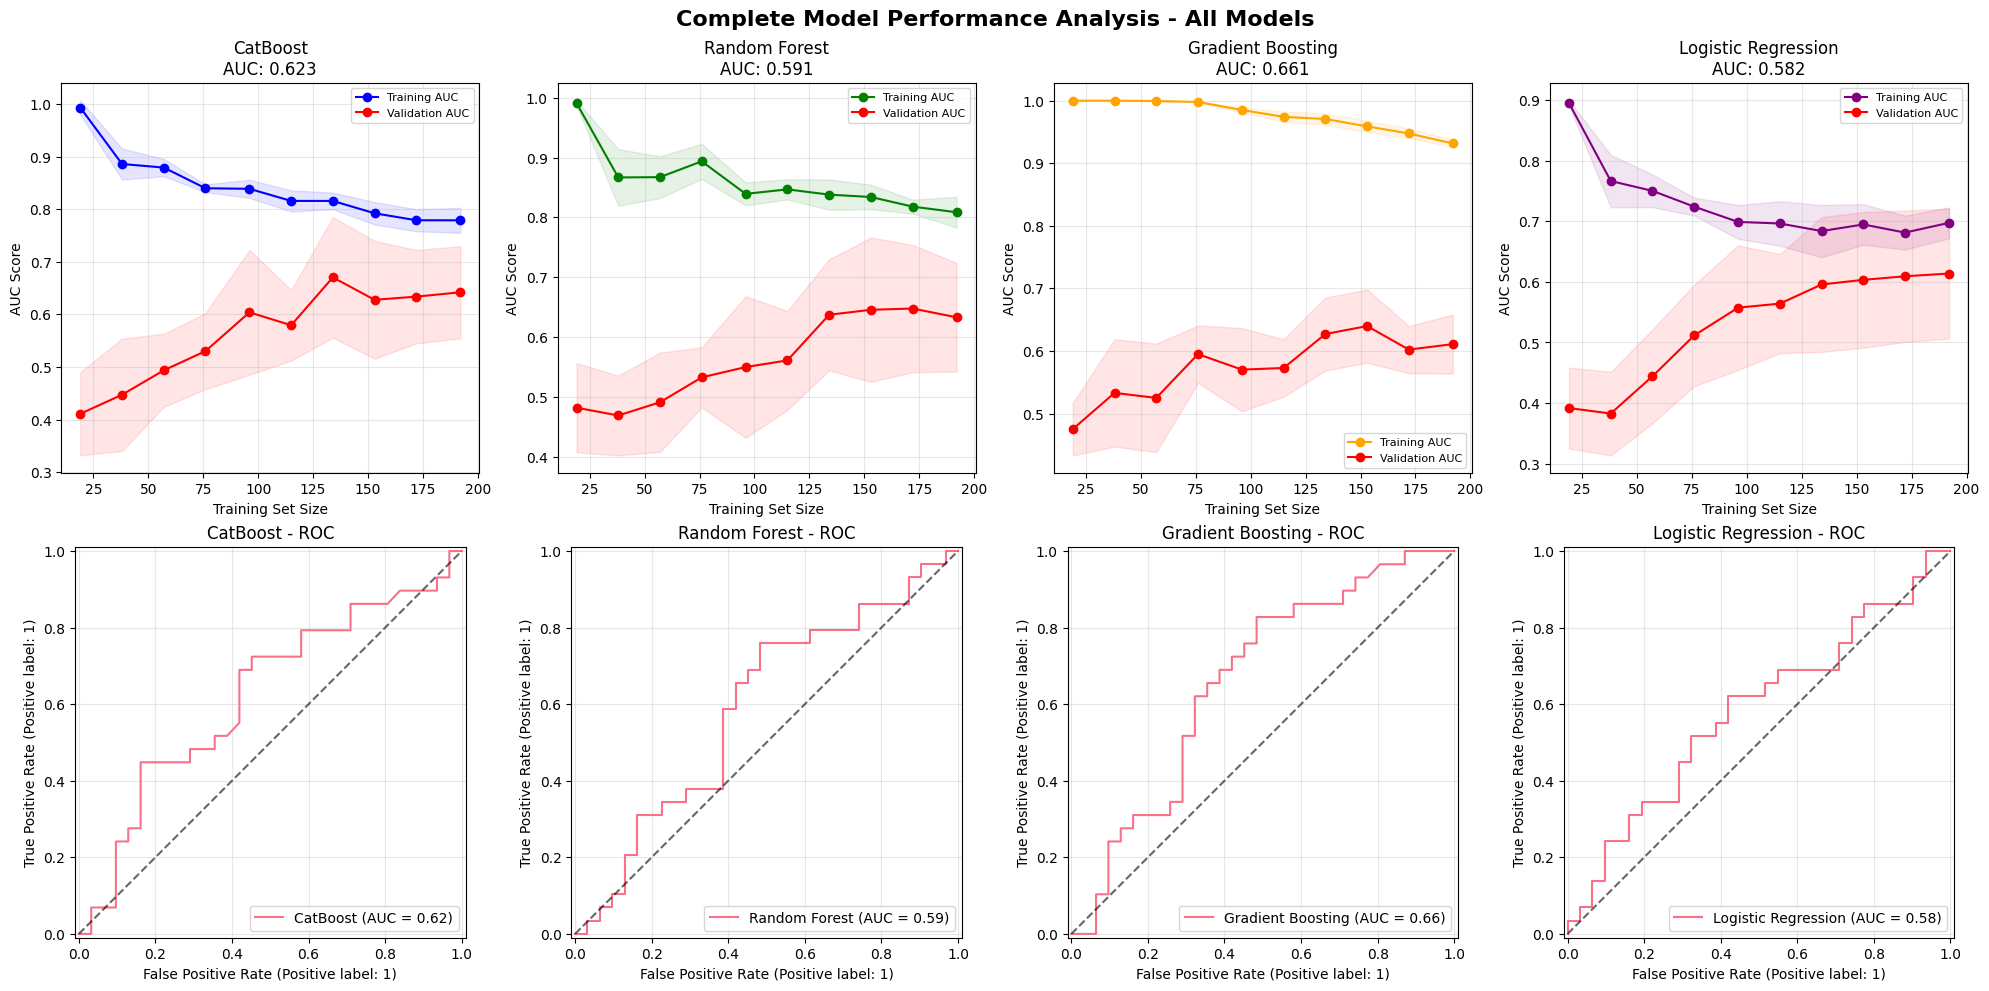

In [11]:
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
fig.suptitle('Complete Model Performance Analysis - All Models', fontsize=16, fontweight='bold')

models_order = ['CatBoost', 'Random Forest', 'Gradient Boosting', 'Logistic Regression']
colors = ['blue', 'green', 'orange', 'purple']

for idx, model_name in enumerate(models_order):
    if model_name in model_results:
        pipeline = model_results[model_name]['pipeline']
        test_pred_proba = model_results[model_name]['test_pred_proba']
        row = comparison_df[comparison_df['Model'] == model_name].iloc[0]
        
        # Learning curve
        train_sizes, train_scores, val_scores = learning_curve(
            pipeline, X_train_final, y_train, cv=5, scoring='roc_auc',
            train_sizes=np.linspace(0.1, 1.0, 10), n_jobs=-1
        )
        
        train_mean = train_scores.mean(axis=1)
        train_std = train_scores.std(axis=1)
        val_mean = val_scores.mean(axis=1)
        val_std = val_scores.std(axis=1)
        
        color = colors[idx]
        
        axes[0, idx].plot(train_sizes, train_mean, 'o-', label='Training AUC', color=color)
        axes[0, idx].fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color=color)
        axes[0, idx].plot(train_sizes, val_mean, 'o-', label='Validation AUC', color='red')
        axes[0, idx].fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.1, color='red')
        axes[0, idx].set_title(f'{model_name}\nAUC: {row["Test_AUC"]:.3f}')
        axes[0, idx].set_xlabel('Training Set Size')
        axes[0, idx].set_ylabel('AUC Score')
        axes[0, idx].legend(fontsize=8)
        axes[0, idx].grid(True, alpha=0.3)
        
        # ROC curve
        RocCurveDisplay.from_predictions(y_test, test_pred_proba, ax=axes[1, idx], name=model_name)
        axes[1, idx].plot([0, 1], [0, 1], 'k--', alpha=0.6)
        axes[1, idx].set_title(f'{model_name} - ROC')
        axes[1, idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [12]:
# Identify best model from comparison_df
best_model_name = comparison_df.iloc[0]['Model']  # Gets name of top performing model
best_model_result = model_results[best_model_name]  # Gets corresponding result dict

print(f"\nBest Model Selected: {best_model_name}")
print(f"Test AUC Score: {best_model_result['test_auc']:.4f}")


Best Model Selected: Gradient Boosting
Test AUC Score: 0.6613


## Final Model Selection and Evaluation

Selecting the best model and evaluating final performance.


In [13]:
# Final model evaluation with best model
best_pipeline = best_model_result['pipeline']

print(f"=== FINAL MODEL EVALUATION ===")
print(f"Selected Best Model: {best_model_name}")
print(f"Test AUC: {best_model_result['test_auc']:.4f}")
print(f"Overfitting Gap: {best_model_result['overfitting_gap']:.4f}")

# Predictions on test set
y_pred = best_pipeline.predict(X_test_final)
y_pred_proba = best_model_result['test_pred_proba']

print(f"\nClassification Report for {best_model_name}:")
print(classification_report(y_test, y_pred))

# Cross-validation on full dataset
cv_scores = cross_val_score(best_pipeline, X_train_final, y_train, cv=5, scoring='roc_auc', n_jobs=-1)
print(f"\nCross-Validation Results:")
print(f"CV AUC Scores: {cv_scores}")
print(f"Mean CV AUC: {cv_scores.mean():.3f}")
print(f"Std CV AUC: {cv_scores.std():.3f}")
print(f"CV AUC Range: {cv_scores.min():.3f} - {cv_scores.max():.3f}")


=== FINAL MODEL EVALUATION ===
Selected Best Model: Gradient Boosting
Test AUC: 0.6613
Overfitting Gap: 0.2417

Classification Report for Gradient Boosting:
              precision    recall  f1-score   support

           0       0.60      0.68      0.64        31
           1       0.60      0.52      0.56        29

    accuracy                           0.60        60
   macro avg       0.60      0.60      0.60        60
weighted avg       0.60      0.60      0.60        60


Cross-Validation Results:
CV AUC Scores: [0.52956522 0.59565217 0.63913043 0.66956522 0.62086957]
Mean CV AUC: 0.611
Std CV AUC: 0.047
CV AUC Range: 0.530 - 0.670


## Feature Importance Analysis

Analyzing feature importance for the selected model.


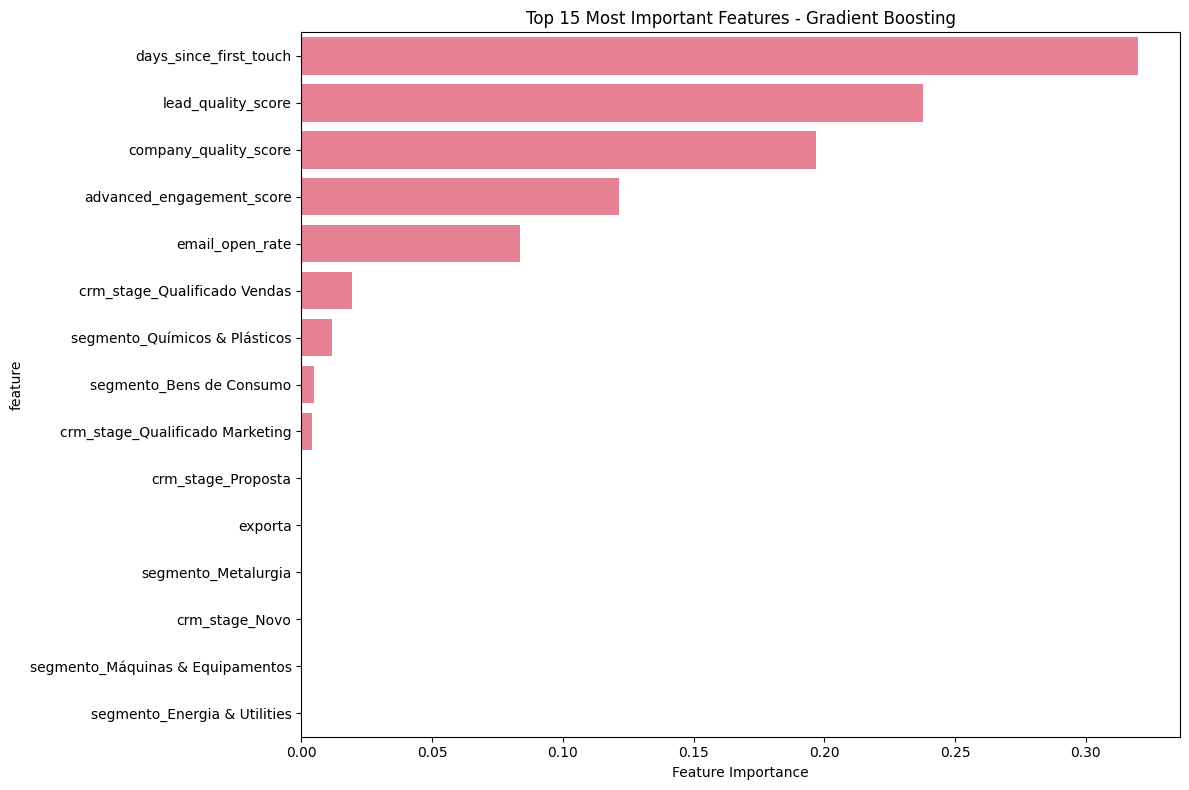

Top 10 Most Important Features:
days_since_first_touch         0.3200
lead_quality_score             0.2376
company_quality_score          0.1968
advanced_engagement_score      0.1216
email_open_rate                0.0836
crm_stage_Qualificado Vendas   0.0195
segmento_Químicos & Plásticos  0.0119
segmento_Bens de Consumo       0.0048
crm_stage_Qualificado Marketing 0.0042
crm_stage_Proposta             0.0000


In [14]:
# Feature importance analysis (CORRECTED - using proper variable names)
if hasattr(best_pipeline.named_steps['classifier'], 'feature_importances_'):
    # Get feature names after preprocessing (FIXED variable names)
    feature_names = (
        final_numeric_features + 
        best_pipeline.named_steps['preprocessor']
        .named_transformers_['cat']
        .get_feature_names_out(final_categorical_features).tolist() +
        final_binary_features
    )
    
    feature_importance = pd.DataFrame({
        'feature': feature_names,
        'importance': best_pipeline.named_steps['classifier'].feature_importances_
    })
    
    plt.figure(figsize=(12, 8))
    top_features = feature_importance.sort_values('importance', ascending=False).head(15)
    sns.barplot(data=top_features, x='importance', y='feature')
    plt.title(f'Top 15 Most Important Features - {best_model_name}')
    plt.xlabel('Feature Importance')
    plt.tight_layout()
    plt.show()
    
    print("Top 10 Most Important Features:")
    for _, row in feature_importance.sort_values('importance', ascending=False).head(10).iterrows():
        print(f"{row['feature']:<30} {row['importance']:.4f}")
        
else:
    # For linear models, use coefficients (CORRECTED variable names)
    feature_names = (
        final_numeric_features + 
        best_pipeline.named_steps['preprocessor']
        .named_transformers_['cat']
        .get_feature_names_out(final_categorical_features).tolist() +
        final_binary_features
    )
    
    coefficients = best_pipeline.named_steps['classifier'].coef_[0]
    feature_importance = pd.DataFrame({
        'feature': feature_names,
        'importance': np.abs(coefficients)
    })
    
    plt.figure(figsize=(12, 8))
    top_features = feature_importance.sort_values('importance', ascending=False).head(15)
    sns.barplot(data=top_features, x='importance', y='feature')
    plt.title(f'Top 15 Most Important Features - {best_model_name} (Absolute Coefficients)')
    plt.xlabel('Feature Importance')
    plt.tight_layout()
    plt.show()
    
    print("Top 10 Most Important Features:")
    for _, row in feature_importance.sort_values('importance', ascending=False).head(10).iterrows():
        print(f"{row['feature']:<30} {row['importance']:.4f}")


## Lead Scoring Implementation

Implementing the lead scoring system with priority assignment.


In [15]:
def optimize_thresholds(y_true, y_pred_proba):
    """Optimize thresholds based on business metrics"""
    thresholds_to_test = np.arange(0.1, 0.9, 0.05)
    best_high = 0.7  # default
    best_medium = 0.4  # default
    best_metrics = None
    
    for high_thresh in thresholds_to_test:
        for med_thresh in thresholds_to_test:
            if med_thresh >= high_thresh:
                continue
                
            # Assign priorities
            priorities = np.where(y_pred_proba >= high_thresh, 'High',
                                np.where(y_pred_proba >= med_thresh, 'Medium', 'Low'))
            
            # Calculate metrics for each priority level
            metrics = {}
            for priority in ['High', 'Medium', 'Low']:
                mask = priorities == priority
                if mask.sum() > 0:
                    conv_rate = y_true[mask].mean()
                    volume = mask.sum() / len(y_true)
                    metrics[priority] = {'conv_rate': conv_rate, 'volume': volume}
            
            # Evaluate thresholds based on business rules
            if (metrics.get('High', {}).get('volume', 0) >= 0.1 and  # At least 10% in High
                metrics.get('High', {}).get('volume', 0) <= 0.3 and  # At most 30% in High
                metrics.get('High', {}).get('conv_rate', 0) > metrics.get('Medium', {}).get('conv_rate', 0)):
                
                if best_metrics is None or metrics['High']['conv_rate'] > best_metrics['High']['conv_rate']:
                    best_high = high_thresh
                    best_medium = med_thresh
                    best_metrics = metrics
    
    return best_high, best_medium

# Optimize thresholds using best model results
optimal_high, optimal_medium = optimize_thresholds(y_test, best_model_result['test_pred_proba'])

def assign_priority(probability, high_threshold=optimal_high, medium_threshold=optimal_medium):
    """Assign priority based on optimized thresholds"""
    if probability >= high_threshold:
        return 'High'
    elif probability >= medium_threshold:
        return 'Medium'
    else:
        return 'Low'

# Score all leads using the enhanced features and best model
X_full_enhanced, _ = create_enhanced_features(X_initial, train_stats)
X_full_final = X_full_enhanced[all_features]

all_probabilities = best_pipeline.predict_proba(X_full_final)[:, 1]
X_full_enhanced['lead_score'] = all_probabilities
X_full_enhanced['priority'] = X_full_enhanced['lead_score'].apply(assign_priority)

In [16]:
# Performance analysis by percentiles
percentiles = [95, 90, 80, 70, 60, 50]
print("=== LEAD SCORING PERFORMANCE ===")
for p in percentiles:
    threshold = np.percentile(all_probabilities, p)
    mask = all_probabilities >= threshold
    conv_rate = y[mask].mean()
    volume = mask.sum()
    pct_total = volume / len(X_full_enhanced) * 100
    
    print(f"Top {100-p:2d}%: Score ≥ {threshold:.3f} | Conv: {conv_rate:.1%} | Volume: {volume:3d} ({pct_total:.1f}%)")

# Priority distribution
priority_dist = X_full_enhanced['priority'].value_counts()
print(f"\nPriority Distribution:")
print(priority_dist)

# Conversion rates by priority
priority_performance = pd.DataFrame({
    'priority': X_full_enhanced['priority'],
    'converted': y
}).groupby('priority')['converted'].agg(['count', 'sum', 'mean'])
priority_performance.columns = ['Total', 'Converted', 'Conversion_Rate']
print(f"\nConversion Rates by Priority (Optimized Thresholds):")
print(priority_performance)


=== LEAD SCORING PERFORMANCE ===
Top  5%: Score ≥ 0.812 | Conv: 86.7% | Volume:  15 (5.0%)
Top 10%: Score ≥ 0.757 | Conv: 93.3% | Volume:  30 (10.0%)
Top 20%: Score ≥ 0.661 | Conv: 88.3% | Volume:  60 (20.0%)
Top 30%: Score ≥ 0.572 | Conv: 83.3% | Volume:  90 (30.0%)
Top 40%: Score ≥ 0.505 | Conv: 80.8% | Volume: 120 (40.0%)
Top 50%: Score ≥ 0.452 | Conv: 76.0% | Volume: 150 (50.0%)

Priority Distribution:
priority
Medium    250
High       50
Name: count, dtype: int64

Conversion Rates by Priority (Optimized Thresholds):
          Total  Converted  Conversion_Rate
priority                                   
High         50         45            0.900
Medium      250         99            0.396


In [17]:
# Sample leads demonstration (FIXED)
sample_leads_raw = pd.DataFrame([
    {
        'segmento': 'Energia & Utilities',
        'faturamento_anual_milhoes': 75.0,
        'numero_SKUs': 150,
        'exporta': 1,
        'margem_media_setor': 18.5,
        'contact_role': 'Diretor de Operações',
        'lead_source': 'Indicação de Cliente',
        'crm_stage': 'Qualificado Marketing',
        'emails_enviados': 5,
        'emails_abertos': 4,
        'emails_respondidos': 2,
        'reunioes_realizadas': 2,
        'download_whitepaper': 1,
        'demo_solicitada': 1,
        'problemas_reportados_precificacao': 1,
        'urgencia_projeto': 1,
        'days_since_first_touch': 45
    },
    {
        'segmento': 'Alimentos & Bebidas',
        'faturamento_anual_milhoes': 25.0,
        'numero_SKUs': 80,
        'exporta': 0,
        'margem_media_setor': 12.0,
        'contact_role': 'Gerente Financeiro',
        'lead_source': 'Inbound (Site)',
        'crm_stage': 'Novo',
        'emails_enviados': 3,
        'emails_abertos': 2,
        'emails_respondidos': 0,
        'reunioes_realizadas': 0,
        'download_whitepaper': 0,
        'demo_solicitada': 0,
        'problemas_reportados_precificacao': 0,
        'urgencia_projeto': 0,
        'days_since_first_touch': 15
    },
    {
        'segmento': 'Construção Civil',
        'faturamento_anual_milhoes': 8.0,
        'numero_SKUs': 30,
        'exporta': 0,
        'margem_media_setor': 8.5,
        'contact_role': 'Coordenador de Custos',
        'lead_source': 'Prospecção Ativa',
        'crm_stage': 'Novo',
        'emails_enviados': 2,
        'emails_abertos': 1,
        'emails_respondidos': 0,
        'reunioes_realizadas': 0,
        'download_whitepaper': 0,
        'demo_solicitada': 0,
        'problemas_reportados_precificacao': 0,
        'urgencia_projeto': 0,
        'days_since_first_touch': 120
    }
])

# Process sample leads using CORRECT function name and stats
sample_leads_processed, _ = create_enhanced_features(sample_leads_raw, train_stats)
sample_features = sample_leads_processed[all_features]  # Use all_features instead of feature_columns
sample_probabilities = best_pipeline.predict_proba(sample_features)[:, 1]  # Use best_pipeline instead of pipeline
sample_priorities = [assign_priority(prob) for prob in sample_probabilities]

# Create results DataFrame (FIXED)
sample_results = pd.DataFrame({
    'Lead_ID': [f'Lead_{i+1}' for i in range(len(sample_leads_processed))],
    'Segment': sample_leads_processed['segmento'].values,
    'Revenue_M': sample_leads_processed['faturamento_anual_milhoes'].values,
    'Contact_Role': sample_leads_processed['contact_role'].values,
    'Lead_Source': sample_leads_processed['lead_source'].values,
    'Total_Touchpoints': sample_leads_processed['total_touchpoints'].values,
    'Proactive_Signals': sample_leads_processed['proactive_signals'].values,
    'Company_Score': sample_leads_processed['company_size_score'].round(3),
    'Engagement_Score': sample_leads_processed['engagement_score'].round(3),
    'Lead_Quality_Score': sample_leads_processed['lead_quality_score'].round(3),
    'Conversion_Probability': [f"{prob:.1%}" for prob in sample_probabilities],
    'Priority': sample_priorities
})

print("Sample Lead Scoring Results:")
sample_results


Sample Lead Scoring Results:


,Lead_ID,Segment,Revenue_M,Contact_Role,Lead_Source,Total_Touchpoints,Proactive_Signals,Company_Score,Engagement_Score,Lead_Quality_Score,Conversion_Probability,Priority
0,Lead_1,Energia & Utilities,75.0,Diretor de Operações,Indicação de Cliente,9,4,0.590,0.8,0.796,62.0%,Medium
1,Lead_2,Alimentos & Bebidas,25.0,Gerente Financeiro,Inbound (Site),3,0,0.269,0.0,0.176,62.4%,Medium
2,Lead_3,Construção Civil,8.0,Coordenador de Custos,Prospecção Ativa,2,0,0.142,0.0,0.103,38.6%,Medium
